In [1]:
import numpy as np
from numpy import array, newaxis, expand_dims
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy as copy
import matplotlib.backends.backend_pdf as pdflib
import scipy as sp
import scipy.stats as stats
import math
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
# plotly.tools.set_credentials_file(username='mhossa10', api_key='CSWpOV3xHUVRzimjfHSB')
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [2]:
color_list1 = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02']
color_list2 = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33']
color_list3 = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c']

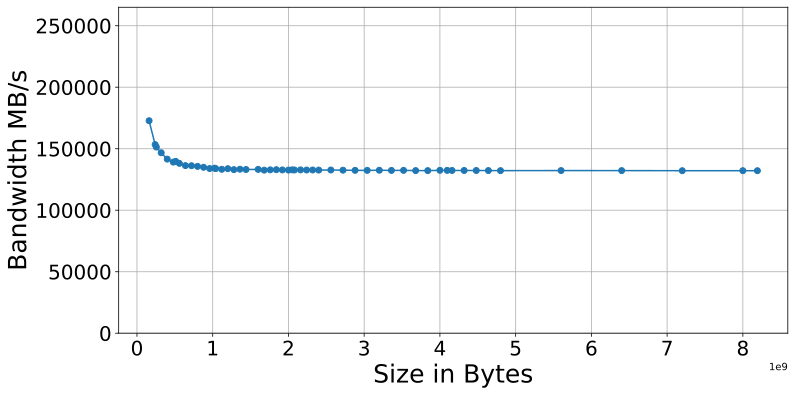

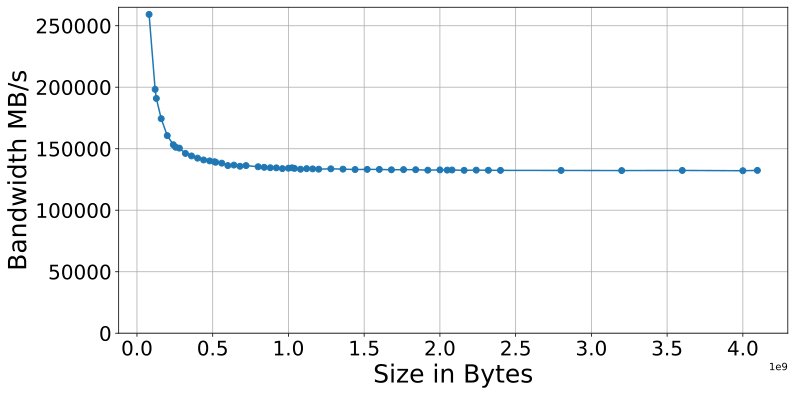

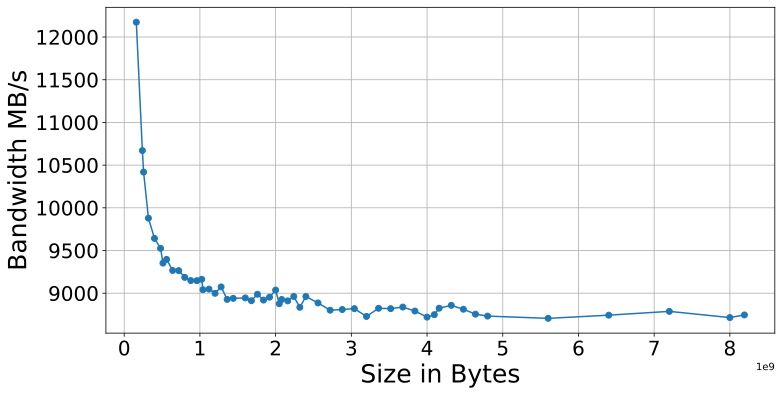

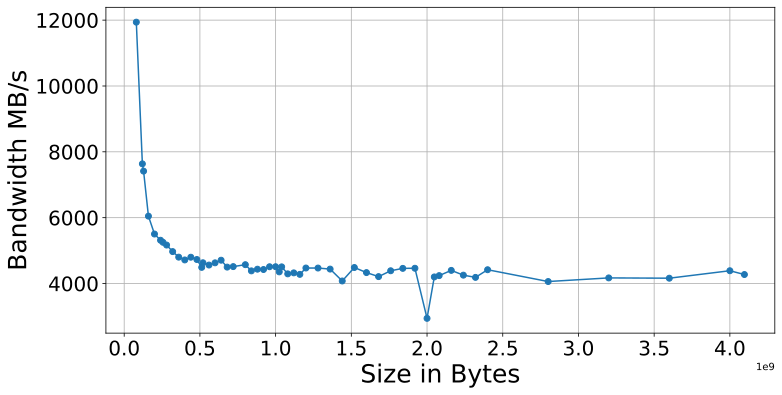

In [4]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")
pdf = pdflib.PdfPages("figures/stream/skylake_mpi_copy_double_precision.pdf")
copy_res = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

pdf = pdflib.PdfPages("figures/stream/skylake_mpi_copy_single_precision.pdf")
copy_res = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True)
ax.set_ylim(0, 265000)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()



pdf = pdflib.PdfPages("figures/stream/skylake_mpi_random_copy_double_precision.pdf")
random_copy_res = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
random_copy_res = random_copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = random_copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True)
# ax.set_ylim(0, 265000)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/stream/skylake_mpi_random_copy_single_precision.pdf")
random_copy_res = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
random_copy_res = random_copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = random_copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True)
# ax.set_ylim(0, 265000)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()



# scal_res = skylake_res[(skylake_res["Operation"] == "Scale") & (skylake_res["DataType"] == 8].sort_values(by="Size").reset_index()
# add_res = skylake_res[(skylake_res["Operation"] == "Add") & (skylake_res["DataType"] == 8].sort_values(by="Size").reset_index()
# triad_res = skylake_res[(skylake_res["Operation"] == "Triad") & (skylake_res["DataType"] == 8].sort_values(by="Size").reset_index()


In [5]:
_pred = pd.DataFrame()
mat = [] 
node = []
prcs = []
rows = []
nnz_r = []
a_time = []
p_time = []
err = []
_model = []
m_size = []

skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")
dp_copy = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_copy = dp_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


min_time_factor = 1.0
if min(dp_copy["AvgTime"]) < 1.0:
    min_time_factor = 1/min(dp_copy["AvgTime"])
for i,r in dp_copy.iterrows():
    dp_copy.at[i, "AvgTime"] = min_time_factor*r["AvgTime"]
    

train_x = dp_copy[["Size"]].to_numpy()
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
X = scaler.fit_transform(train_x)
column = "AvgTime"
train_y = np.array(dp_copy[column])
test_y = train_y
scores = []
best = 0
# c=20e4
# e=0.001
for c in np.linspace(2e1,6e4, num=50):
    for e in np.linspace(0.0001, 0.9, 20):
        best_svr = SVR(kernel='poly', C=c, gamma='auto', degree=3, epsilon=e, coef0=1)
        cv = KFold(n_splits=5, random_state=42, shuffle=True)
        for train_index, test_index in cv.split(X):
            X_train, X_test, y_train, y_test = X[train_index], X[test_index], train_y[train_index], train_y[test_index]
            best_svr.fit(X_train, y_train)
            scores.append(best_svr.score(X_test, np.array(y_test)))
            if best < np.mean(scores):
                best = np.mean(scores)
                best_param = {"C": c, "epsilon": e}
svr = SVR(kernel='poly', C=best_param['C'], gamma='auto', degree=3, epsilon=best_param['epsilon'], coef0=1)
svr.fit(X, train_y)
y_pred = svr.predict(X)

max_err = 0
avg_err = 0
for i,row in dp_copy.iterrows():
#     print(y[index])
#     g = row["Name"].split("_")
    print(row["Size"], '{0:.5g}'.format(test_y[i]/min_time_factor),"&",'{0:.5g}'.format(y_pred[i]/min_time_factor), "&", 
          '{0:.4g}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])+"\\%", "\\\ \hline")           
    if max_err < abs(test_y[i]-y_pred[i])*100/test_y[i]:
        max_err = abs(test_y[i]-y_pred[i])*100/test_y[i]
    avg_err += abs(test_y[i]-y_pred[i])*100/test_y[i]
    rows.append(row["Size"])
    a_time.append(float('{0:.5g}'.format(test_y[i]/min_time_factor)))
    p_time.append(float('{0:.5g}'.format(y_pred[i]/min_time_factor)))
    err.append(float('{0:.4g}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])))
    _model.append("Double Precision")
# omp_data.groupby("Threads").count()
print("best param: ", best_param)
print("max error: ", max_err, " avg error: ", avg_err/dp_copy.shape[0])
    
_pred["Sizes"] = rows
_pred["Model"] = _model
_pred["Actual Time"] = a_time
_pred["Predicted Time"] = p_time
_pred["Error"] = err

80000000.0 0.0068215 & 0.011347 & 66.34\% \\ \hline
120000000.0 0.015903 & 0.020233 & 27.23\% \\ \hline
128000000.0 0.017397 & 0.022016 & 26.55\% \\ \hline
160000000.0 0.026595 & 0.029164 & 9.663\% \\ \hline
200000000.0 0.036625 & 0.03814 & 4.137\% \\ \hline
240000000.0 0.04541 & 0.047159 & 3.853\% \\ \hline
256000000.0 0.048954 & 0.050779 & 3.729\% \\ \hline
280000000.0 0.054505 & 0.056221 & 3.149\% \\ \hline
320000000.0 0.064544 & 0.065324 & 1.21\% \\ \hline
360000000.0 0.075198 & 0.074468 & 0.97\% \\ \hline
400000000.0 0.085028 & 0.083651 & 1.62\% \\ \hline
440000000.0 0.091956 & 0.092872 & 0.9964\% \\ \hline
480000000.0 0.10168 & 0.10213 & 0.4426\% \\ \hline
512000000.0 0.1142 & 0.10956 & 4.055\% \\ \hline
520000000.0 0.11251 & 0.11143 & 0.9653\% \\ \hline
560000000.0 0.12303 & 0.12076 & 1.851\% \\ \hline
600000000.0 0.13003 & 0.13012 & 0.06665\% \\ \hline
640000000.0 0.13624 & 0.13952 & 2.404\% \\ \hline
680000000.0 0.15149 & 0.14895 & 1.681\% \\ \hline
720000000.0 0.15977 & 0.158

FileNotFoundError: [Errno 2] No such file or directory: 'paper/figures/stream/skylake_mpi_random_copy_double_precision_time.pdf'

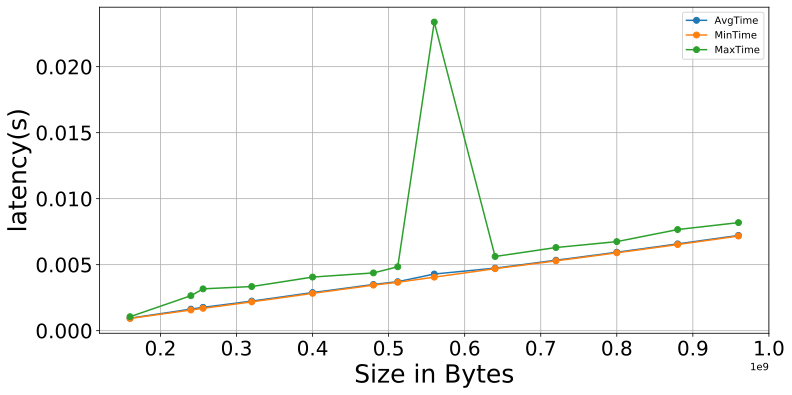

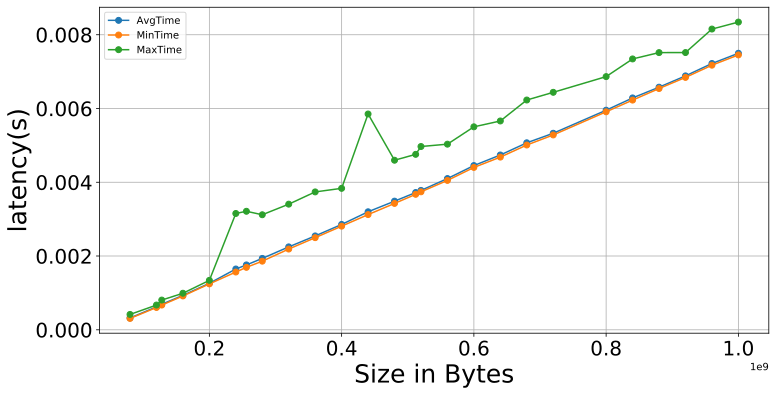

In [6]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")
pdf = pdflib.PdfPages("figures/stream/skylake_mpi_copy_double_precision_time.pdf")
copy_res = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
copy_res = copy_res[copy_res["Size"] <= 1000000000]
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y=["AvgTime", "MinTime", "MaxTime"], style="-o", figsize=(12,6), fontsize=20)
ax.set_ylabel("latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/stream/skylake_mpi_copy_single_precision_time.pdf")
copy_res = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
copy_res = copy_res[copy_res["Size"] <= 1000000000]
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y=["AvgTime", "MinTime", "MaxTime"], style="-o", figsize=(12,6), fontsize=20)
ax.set_ylabel("latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("paper/figures/stream/skylake_mpi_random_copy_double_precision_time.pdf")
random_copy_res = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
random_copy_res = random_copy_res[random_copy_res["Size"] <= 1000000000]
random_copy_res = random_copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = random_copy_res.plot(kind="line", ax=ax1, x="Size", y=["AvgTime", "MinTime", "MaxTime"], style="-o", figsize=(12,6), fontsize=20)
ax.set_ylabel("latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

pdf = pdflib.PdfPages("paper/figures/stream/skylake_mpi_random_copy_single_precision_time.pdf")
random_copy_res = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
random_copy_res = random_copy_res[random_copy_res["Size"] <= 1000000000]
random_copy_res = random_copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = random_copy_res.plot(kind="line", ax=ax1, x="Size", y=["AvgTime", "MinTime", "MaxTime"], style="-o", figsize=(12,6), fontsize=20)
ax.set_ylabel("latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

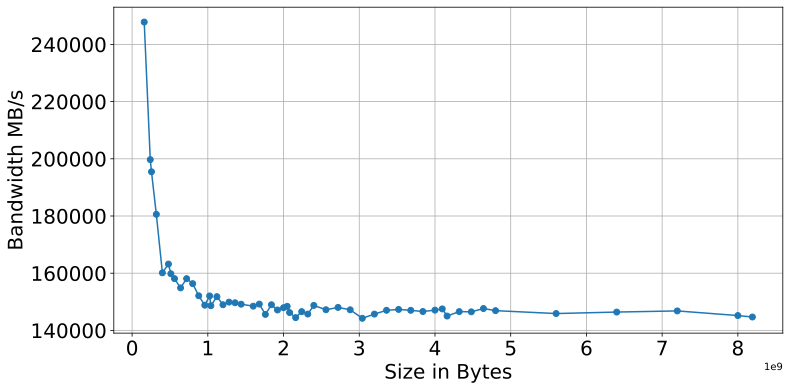

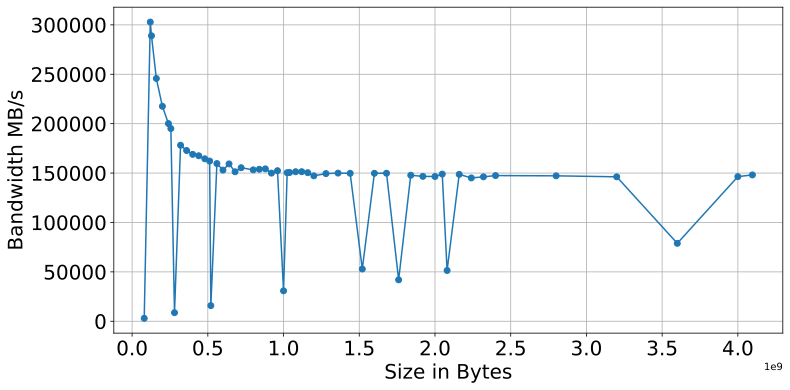

In [7]:
cascade_lake_res = pd.read_csv("../../STREAM/Results/CASCADE_LAKE.csv")
pdf = pdflib.PdfPages("figures/stream/cascade_lake_mpi_copy_double_precision.pdf")
copy_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Copy") & (cascade_lake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=20)
ax.set_xlabel("Size in Bytes", fontsize=20)
ax.grid(True)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/stream/cascade_lake_mpi_copy_single_precision.pdf")
copy_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Copy") & (cascade_lake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=20)
ax.set_xlabel("Size in Bytes", fontsize=20)
ax.grid(True)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


# scal_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Scale") & (cascade_lake_res["DataType"] == 8].sort_values(by="Size").reset_index()
# add_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Add") & (cascade_lake_res["DataType"] == 8].sort_values(by="Size").reset_index()
# triad_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Triad") & (cascade_lake_res["DataType"] == 8].sort_values(by="Size").reset_index()


# OSU Benchmark

# Cascade Lake

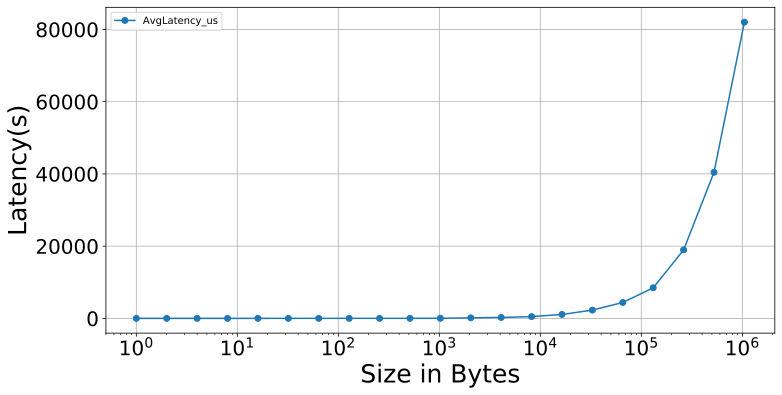

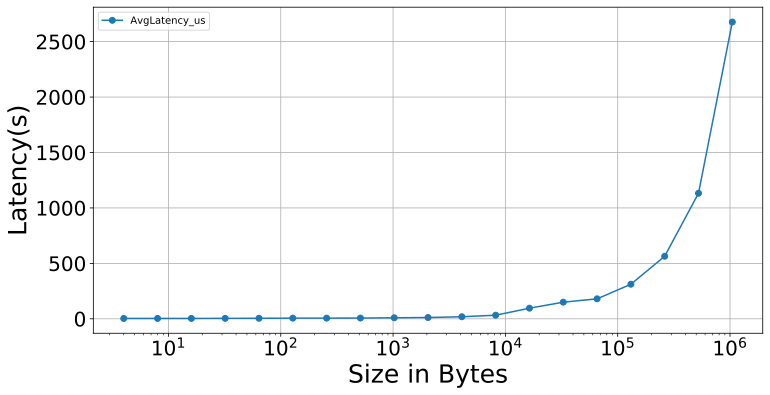

In [10]:
seq_bandwidth = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/cascade_allgatherv.csv")
seq_bandwidth = seq_bandwidth.groupby("Size").mean().reset_index()

pdf = pdflib.PdfPages("figures/osu/cascade_lake_mpi_allgatherv.pdf")
fig1,ax1 = plt.subplots()
ax = seq_bandwidth.plot(kind="line", ax=ax1, x="Size", y="AvgLatency_us", figsize=(12,6), fontsize=20, style="-o", logx=True)
ax.set_ylabel("Latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/osu/cascade_lake_mpi_allreduce.pdf")
fig1,ax1 = plt.subplots()
seq_bandwidth = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/cascade_allreduce.csv")
seq_bandwidth = seq_bandwidth.groupby("Size").mean().reset_index()
ax = seq_bandwidth.plot(kind="line", ax=ax1, x="Size", y="AvgLatency_us", figsize=(12,6), fontsize=20, style="-o", logx=True)
ax.set_ylabel("Latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

# Skylake

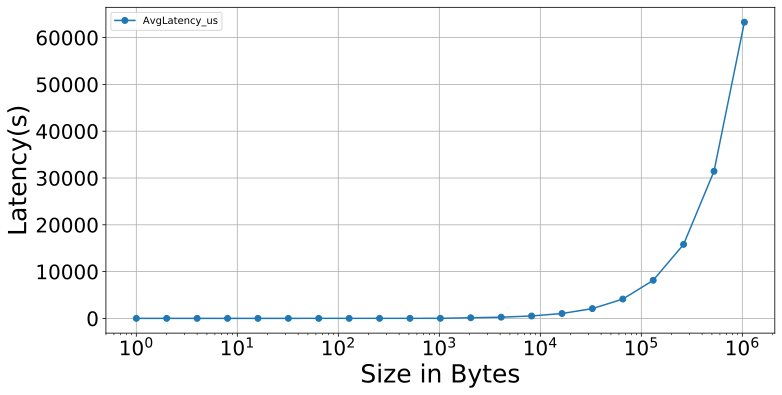

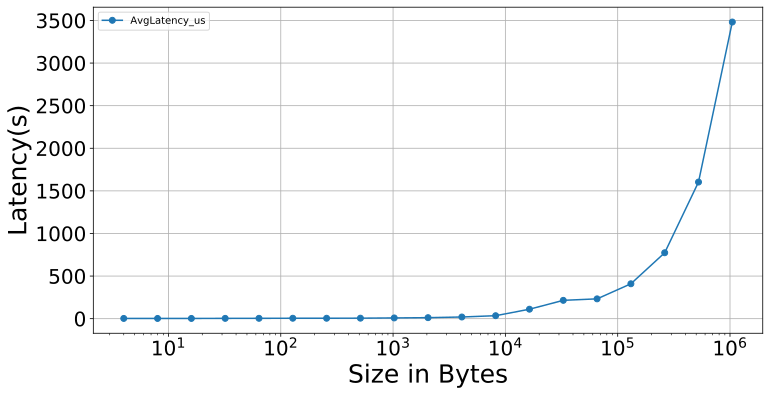

In [11]:
seq_bandwidth = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/skylake_allgatherv.csv")
seq_bandwidth = seq_bandwidth.groupby("Size").mean().reset_index()

pdf = pdflib.PdfPages("figures/osu/skylake_mpi_allgatherv.pdf")
fig1,ax1 = plt.subplots()
ax = seq_bandwidth.plot(kind="line", ax=ax1, x="Size", y="AvgLatency_us", figsize=(12,6), fontsize=20, style="-o", logx=True)
ax.set_ylabel("Latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/osu/skylake_mpi_allreduce.pdf")
fig1,ax1 = plt.subplots()
seq_bandwidth = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/skylake_allreduce.csv")
seq_bandwidth = seq_bandwidth.groupby("Size").mean().reset_index()
ax = seq_bandwidth.plot(kind="line", ax=ax1, x="Size", y="AvgLatency_us", figsize=(12,6), fontsize=20, style="-o", logx=True)
ax.set_ylabel("Latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

# FMA FLOPS

# MPI

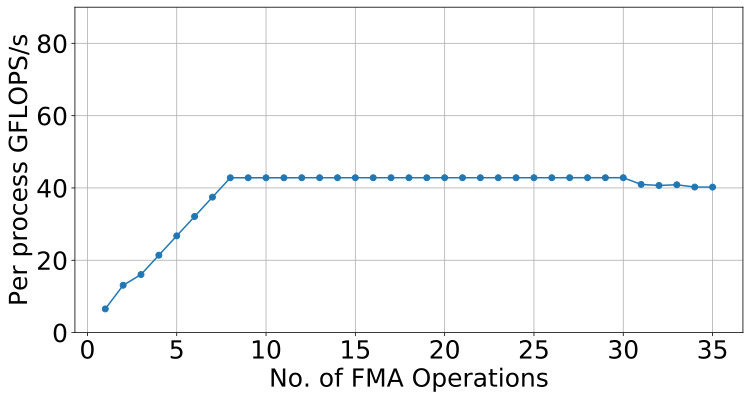

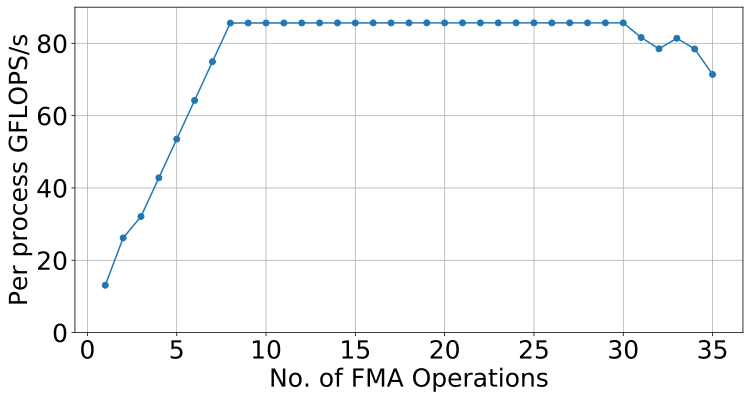

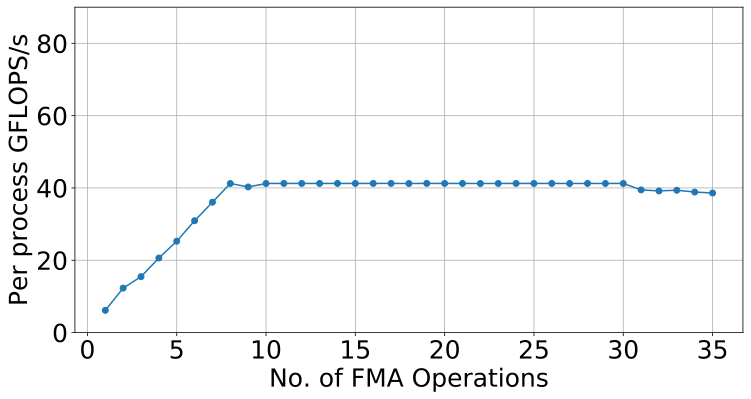

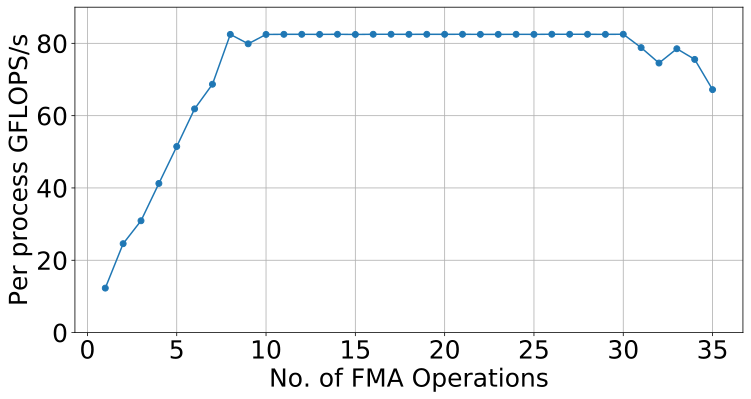

In [8]:
fmaRes = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/FMA_ON_SKYLAKE.csv")
fmaRes = fmaRes.groupby(["ChainedFMAs", "VectorWidth"]).mean().reset_index()
for vec,vec_data in fmaRes.groupby("VectorWidth"):
    pdf = pdflib.PdfPages("figures/fma/skylake_mpi_fma_roofline_model_for_vec_" + str(vec) + ".pdf")
    fig1,ax1 = plt.subplots()
    vec_data = vec_data.sort_values(by="ChainedFMAs").reset_index(drop=True)
    ax = vec_data.plot(kind="line", style="-o", ax=ax1, x="ChainedFMAs", legend=False, y="AvgGFLOPSPerSec", figsize=(12,6))
    ax.grid(True)
    ax.set_ylim(0,90)
    ax.set_ylabel("Per process GFLOPS/s", fontsize=25)
    ax.set_xlabel("No. of FMA Operations", fontsize=25)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
#     ax.set_title("Skylake: Roofline model for bandwidth for FMA operation for vector width: " + str(vec))
    pdf.savefig(fig1, bbox_inches = 'tight')
    pdf.close()
    
fmaRes = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/FMA_ON_CASCADE_LAKE.csv")
fmaRes = fmaRes.groupby(["ChainedFMAs", "VectorWidth"]).mean().reset_index()
for vec,vec_data in fmaRes.groupby("VectorWidth"):
    pdf = pdflib.PdfPages("figures/fma/cascade_lake_mpi_fma_roofline_model_for_vec_" + str(vec) + ".pdf")
    fig2,ax2 = plt.subplots()
    vec_data = vec_data.sort_values(by="ChainedFMAs").reset_index(drop=True)
    ax = vec_data.plot(kind="line", style="-o", ax=ax2, x="ChainedFMAs", legend=False, y="AvgGFLOPSPerSec", figsize=(12,6))
    ax.grid(True)
    ax.set_ylim(0,90)
    ax.set_ylabel("Per process GFLOPS/s", fontsize=25)
    ax.set_xlabel("No. of FMA Operations", fontsize=25)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
#     ax.set_title("Cascade Lake: Roofline model for bandwidth for FMA operation for vector width: " + str(vec))
    pdf.savefig(fig2, bbox_inches = 'tight')
    pdf.close()
    
    

# OpenMP

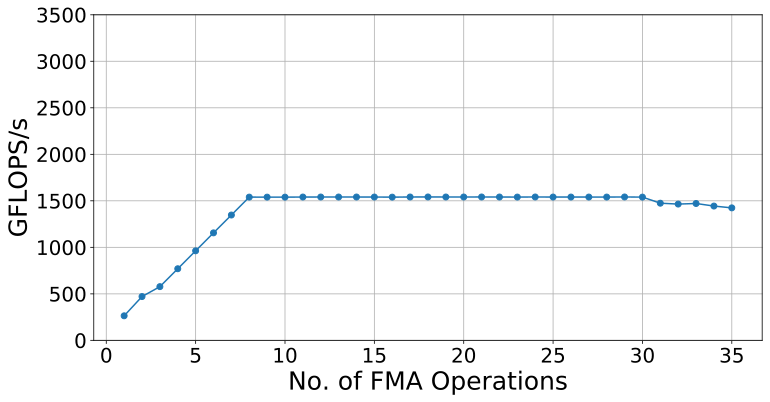

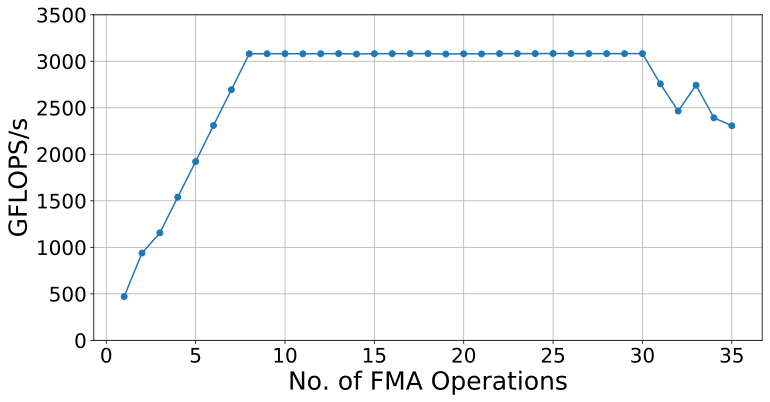

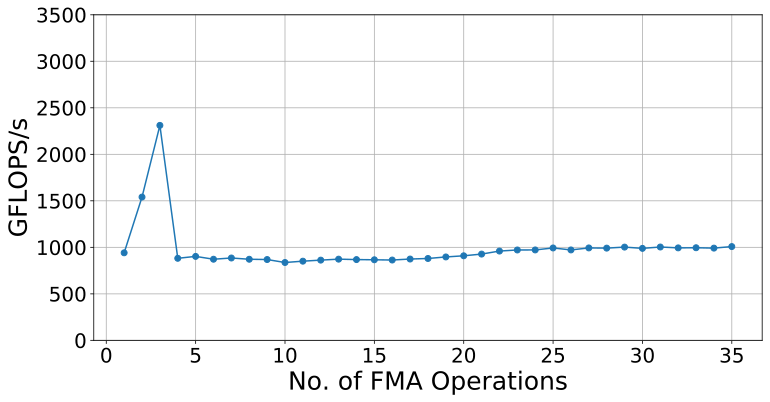

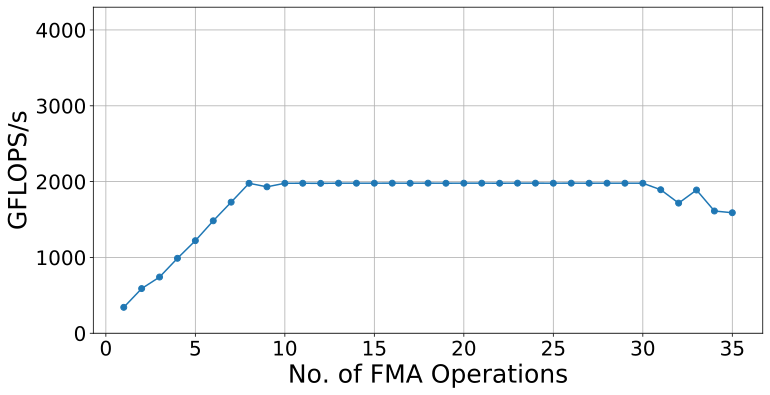

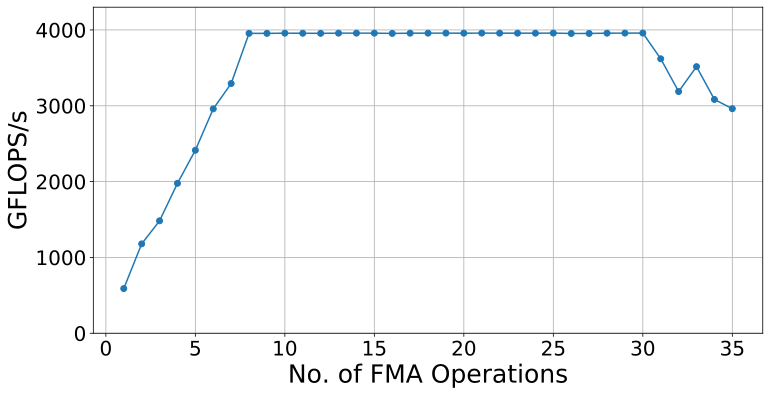

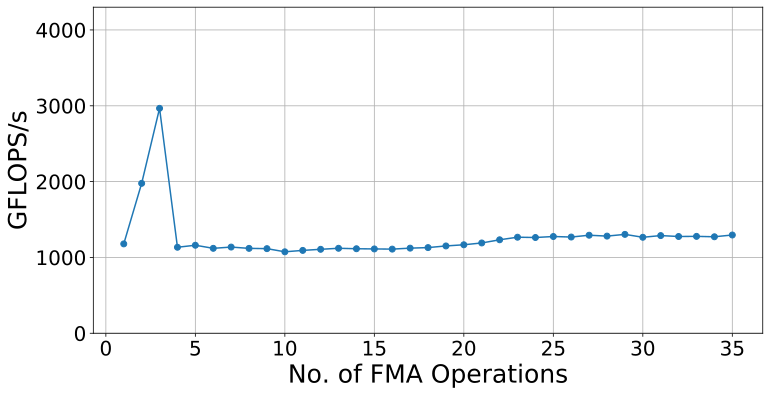

In [9]:
fmaRes = pd.read_csv("../../SpMVMicroBenchmark/omp/Results/FMA_ON_SKYLAKE.csv")
fmaRes = fmaRes.groupby(["ChainedFMAs", "VectorWidth"]).mean().reset_index()

for vec,vec_data in fmaRes.groupby("VectorWidth"):
    pdf = pdflib.PdfPages("figures/fma/skylake_omp_fma_roofline_model_for_vec_" + str(vec) + ".pdf")
    fig1,ax1 = plt.subplots()
    vec_data = vec_data.sort_values(by="ChainedFMAs").reset_index(drop=True)
    ax = vec_data.plot(kind="line", ax=ax1, style="-o", x="ChainedFMAs", legend=False, y="GFLOPSPerSec", figsize=(12,6))
    ax.grid(True)
    ax.set_ylim(0,3500)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_ylabel("GFLOPS/s", fontsize=25)
    ax.set_xlabel("No. of FMA Operations", fontsize=25)
#     ax.set_title("Skylake: Roofline model for bandwidth for FMA operation for vector width: " + str(vec))
    pdf.savefig(fig1, bbox_inches = 'tight')
    pdf.close()

fmaRes = pd.read_csv("../../SpMVMicroBenchmark/omp/Results/FMA_ON_CASCADE_LAKE.csv")
fmaRes = fmaRes.groupby(["ChainedFMAs", "VectorWidth"]).mean().reset_index()
for vec,vec_data in fmaRes.groupby("VectorWidth"):
    pdf = pdflib.PdfPages("figures/fma/cascade_lake_omp_fma_roofline_model_for_vec_" + str(vec) + ".pdf")
    fig2,ax2 = plt.subplots()
    vec_data = vec_data.sort_values(by="ChainedFMAs").reset_index(drop=True)
    ax = vec_data.plot(kind="line", style="-o", ax=ax2, x="ChainedFMAs", legend=False, y="GFLOPSPerSec", figsize=(12,6))
    ax.grid(True)
    ax.set_ylim(0,4300)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_ylabel("GFLOPS/s", fontsize=25)
    ax.set_xlabel("No. of FMA Operations", fontsize=25)
#     ax.set_title("Cascade Lake: Roofline model for bandwidth for FMA operation for vector width: " + str(vec))
    
    pdf.savefig(fig2, bbox_inches = 'tight')
    pdf.close()
    